In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os, pickle
sys.path.append('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/code/multiple_barriers')
from multiple_barriers.agent_replay import AgentPOMDP
from multiple_barriers.utils import plot_maze, load_env, plot_need

In [16]:
env            = 'tolman123'
env_file_path  = '/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/code/mazes/' + env + '.txt'
env_config     = load_env(env_file_path)

# --- Specify agent parameters ---
pag_config = {
    'alpha'          : 1,
    'beta'           : 2, 
    'need_beta'      : 2,
    'gain_beta'      : 60,          
    'gamma'          : 0.9,
    'policy_type'    : 'softmax'
}

ag_config = {
    'alpha_r'        : 1,         # offline learning rate
    'horizon'        : 11,         # planning horizon (minus 1)
    'xi'             : 0.001,     # EVB replay threshold
    'num_sims'       : 2000,      # number of MC simulations for need
    'sequences'      : False,
    'max_seq_len'    : 5,        
    'env_name'       : env,       # gridworld name
}

env_config['barriers'] = [1, 1, 0]

agent = AgentPOMDP(*[pag_config, ag_config, env_config])

### Example replays

In [17]:
Q_MB  = agent._solve_mb(1e-5)

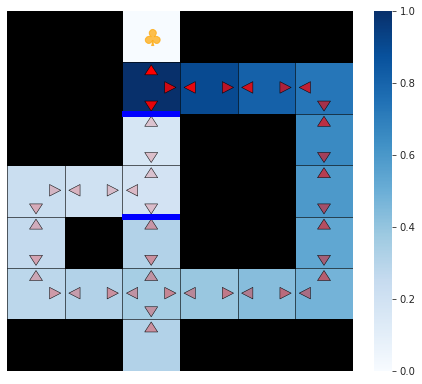

In [18]:
fig = plt.figure(figsize=(6, 5))
ax  = fig.add_axes([0, 0, 1, 1])
plot_maze(ax, Q_MB, agent)
# plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/rldm_poster/tolman1/q_mb.svg', transparent=True)

In [19]:
agent.Q           = Q_MB.copy()
agent.M           = np.array([[7, 2], [4, 10], [1, 0]])
agent.belief_tree = agent._build_belief_tree()
traj_tree         = agent._simulate_trajs()
pneed_tree        = agent._build_pneed_tree(traj_tree)
updates           = agent._generate_single_updates(pneed_tree)

In [20]:
for hi in range(agent.horizon):
    for k, val in agent.belief_tree[hi].items():
        if agent.belief_tree[hi][k][0][1] == 14:
            print(hi, k)

4 0
5 1
8 4
9 5


In [27]:
agent.belief_tree[8][4]

[[array([[ 0,  1],
         [ 4, 10],
         [ 1,  0]]),
  14],
 array([[       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [0.        , 0.        , 0.        , 0.        ],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [1.        , 0.9       ,        nan, 0.81      ],
        [       nan,        nan, 0.9       , 0.729     ],
        [       nan,        nan, 0.81      , 0.6561    ],
        [       nan, 0.59049   , 0.729     ,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [0.15009464, 0.16677182,        nan,        nan],
        [       nan,        nan,        nan,        nan],
      

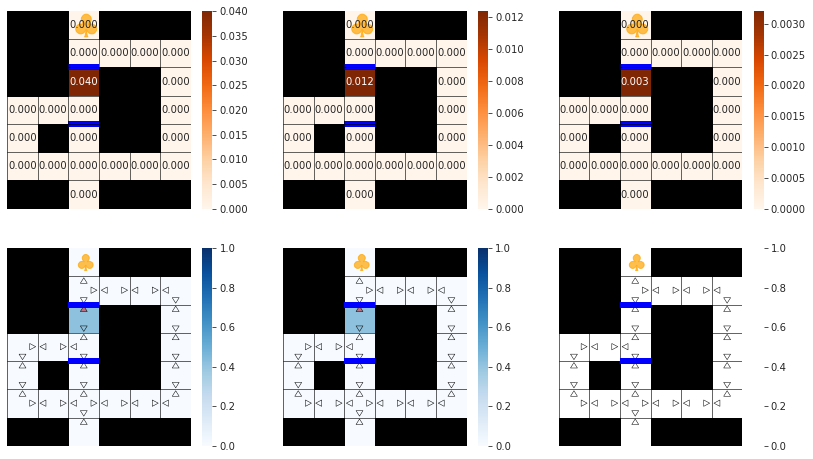

In [21]:
fig  = plt.figure(figsize=(14, 8))

idcs = [[4, 0], [8, 4], [9, 5]]

for plt_idx, (hip, kp) in enumerate(idcs):

    b = agent.belief_tree[hip][kp][0][0]

    need = np.zeros(agent.num_states)
    need[agent.nan_states] = np.nan
            

    for idx, upd in enumerate(updates):
        hi, k = upd[0], upd[1]
        if hi == hip and k == kp:
            sp, ap   = upd[2][0, :]
            gain_val = upd[-3][0][hi[0]][k[0]]
            need[sp]  = pneed_tree[hi[0]][k[0]]
            break

    ax   = plt.subplot(2, 3, plt_idx+1)
    plot_need(ax, need, agent, normalise=False, colormap='Oranges')

    Gain = agent.Q_nans.copy()
    Gain[sp, ap] = gain_val
    ax   = plt.subplot(2, 3, plt_idx+4)
    plot_maze(ax, Gain, agent)


### Exploration probability

In [ ]:
np.random.seed(2)

agent.M      = np.array([[1, 1], [0, 1], [1, 0]])

agent.state  = 38 # start state
M_range      = [[0, 1], [1, 7], [1, 5], [1, 3], [1, 1], [3, 1], [5, 1], [7, 1], [1, 0]]
qs           = []

for M in M_range:
    agent.Q       = Q_MB.copy()
    agent.M[0, :] = M
    
    _, _, _  = agent._replay()
    
    Q_after  = agent.Q.copy()
    
    qs      += [Q_after[14, :].copy(), Q_after[20, :].copy(), Q_after[19, :].copy(), Q_after[18, :].copy(), Q_after[24, :].copy(), Q_after[30, :].copy(), Q_after[31, :].copy(), Q_after[32, :].copy()]

In [ ]:
betas = [1, 5, 10, 20]

x = np.arange(len(M_range))

for beta in betas:

    agent.beta = beta
    probs = np.zeros(len(M_range))
    for i in range(0, len(qs), 8):
        probs[i//8] = agent._policy(qs[i])[0]*agent._policy(qs[i+1])[0]*agent._policy(qs[i+2])[3]*agent._policy(qs[i+3])[3]*agent._policy(qs[i+4])[0]*agent._policy(qs[i+5])[0]*agent._policy(qs[i+6])[2]*agent._policy(qs[i+7])[2]
    plt.plot(x, probs, label=r'$\beta=%u$'%beta)

probs = np.zeros(len(M_range))
for i in range(7, len(qs), 8):
    probs[i//8] = (qs[i][2] == np.nanmax(qs[i]))
plt.plot(x, probs, label='greedy')

plt.ylim(-0.05, 1.05)
# plt.xlim(0, 1)

plt.xticks(x, np.linspace(0, 1, len(x)), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Belief', fontsize=14)
plt.ylabel('Exploration probability', fontsize=14)
plt.legend(prop={'size':12})
plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/paper/figures/fig5/fig5.png')

In [ ]:
import scipy

a, b = 5, 2

x = np.linspace(0, 1, 100)

plt.plot(x, scipy.stats.beta.pdf(x, a, b), 'r-', lw=5, alpha=0.6, label='beta pdf')